In [1]:
import pandas as ps
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import argparse
import sys,code

random.seed(40579)

class Config:
    T = 100  # time (1000)f
    N = 1000 # number of firms (10000)
    Ñ = 180   # size parameter

    
    c = 1     # parameter bankruptcy cost equation
    α = 0.08  # alpha, ratio equity-loan
    g = 1.1   # variable cost
    ω = 0.002 # markdown interest rate (the higher it is, the monopolistic power of banks)
    λ = 0.3   # credit assets rate
    d = 100   # location cost
    e = 0.1   # sensivity

    # firms initial parameters
    K_i0 = 100   # capital
    A_i0 = 20    # asset
    L_i0 = 80    # liability
    π_i0 = 0     # profit
    B_i0 = 0     # bad debt

    # risk coefficient for bank sector (Basel)
    v    = 0.2
    
    delta1 = 0.001
    delta2 = 0.002    
    
    
    sigma = 0.01 # 0.02-0.05
    beta = 2  # bernoulli 
    
    thresold_green = 0.5

In [2]:
class Statistics:
    doLog = False
    def log(cadena):
        if Statistics.doLog:
            print(cadena)

    firms = []
    bankSector = []

    bankrupcy = []
    firmsK = []
    firmsπ = []
    firmsL = []
    firmsB = []
    firmsY = []
    firmsφ = []
    firmsz = []
    firmsmu= []
    
    rate   = []

    def getStatistics():
        global args

        Statistics.log("t=%4s [firms] n=%s,sumA=%.2f,sumL=%.2f,sumK=%.2f,sumπ=%2.f" % ( Status.t,len(Status.firms), \
                                                                   Status.firmsAsum,Status.firmsLsum,
                                                                   Status.firmsKsum,Status.firmsπsum))
        Statistics.log("       [bank]  avgRate=%.2f,D=%.2f,L=%.2f,E=%0.2f,B=%.2f,π=%.2f" % ( BankSector.getAverageRate() , \
                                                                   BankSector.D,BankSector.L,BankSector.E,
                                                                   BankSector.B,BankSector.π))
        ##Statistics.log( " r=%s " % Status.firms[0].r )

        Statistics.firmsK.append( Status.firmsKsum )
        Statistics.firmsπ.append( Status.firmsπsum )
        Statistics.firmsL.append( Status.firmsLsum )
        Statistics.firmsY.append( Status.firmsYsum )
        Statistics.firmsφ.append( Status.firmsφsum )
        Statistics.firmsB.append( BankSector.B )
        Statistics.rate.append( BankSector.getAverageRate() )
        
        mu = 0
        zeta = []
        for i in Status.firms:
            mu += i.mu
            zeta.append( i.zeta )
        Statistics.firmsz.append( zeta )
        Statistics.firmsmu.append( mu ) 

            
class Status:
    firms = []
    firmsKsum = 0.0
    firmsAsum = 0.0
    firmsLsum = 0.0
    firmsπsum = 0.0
    
    firmsYsum = 0.0
    firmsφsum = 0.0
    numFailuresGlobal = 0
    t = 0


    firmsKsums = []
    firmsGrowRate = []

    firmIdMax = 0
    def getNewFirmId():
        Status.firmIdMax += 1
        return Status.firmIdMax

    @staticmethod
    def initialize():
        for i in range(Config.N):
            Status.firms.append( Firm() )
            
            
class Firm():
    K = Config.K_i0   # capital
    A = Config.A_i0   # asset
    r = 0.0           # rate money is given by banksector
    L = Config.L_i0   # credit
    π = 0.0           # profit
    u = 0.0
    φ = 0.1           # initial capital productivity 
    
    mu= 0.0
    zeta= 0.0
    
    green = False
    
    
    innovation = 0.0  # cuanto ha destinado a i+d+i
    
    
    def __init__(self):
        self.id = Status.getNewFirmId()

    def determineCredit(self):
        # (equation 11)
        result = Config.λ * BankSector.L * self.K / Status.firmsKsum + (1 - Config.λ) * BankSector.L * self.A / Status.firmsAsum
        ## Statistics.log( "a*%s*%s/%s+(1-a)*%s*%s/%s  L=%s" % (BankSector.L,self.K,Status.firmsKsum,BankSector.L,self.A,Status.firmsAsum,result))
        return result
 
    def determineInterestRate(self):
        # (equation 12)
        return (2 + self.A ) / (  2 * Config.c * Config.g * ( 1/ ( Config.c * self.φ ) + self.π + self.A  ) + \
                                  2 * Config.c * Config.g * BankSector.L * ( Config.λ*self.__ratioK() + (1-Config.λ)*self.__ratioA() ) )
    def __ratioK(self):
        return self.K / Status.firmsKsum
    def __ratioA(self):
        return self.A / Status.firmsAsum

    def determineCapital(self):
        # equation 9
        return ( self.φ - Config.g * self.r ) / (Config.c * self.φ * Config.g * self.r) + (self.A / (2 * Config.g * self.r))


    def determineU(self):
        return random.random()*2

    def determineAssets(self):
        # equation 6
        return self.A + self.π # K - self.L

    def determineProfit(self):
        # equation 5
        result =  ( self.u * self.φ - Config.g * self.r ) * self.K
        if result>0:
            self.innovation = Config.sigma*result            
            self.mu = self.innovation / self.K
            self.zeta = 1 -  math.exp( -Config.beta * self.mu )
            
        result -= (Config.sigma*result)        
        return result
    def determineφ(self):
        if self.zeta>0.025:#el problema de darle un valor a zeta es que si tenemos que jugar con sigma, al cambiar sigma cambiaran los valores de z
            self.φ = self.φ * (1 + random.uniform( Config.delta1, Config.delta2 ))
        else: 
            self.φ=self.φ
            return self.φ
    
class BankSector():
    E = Config.N * Config.L_i0 * Config.v
    B = Config.B_i0   # bad debt
    D = 0
    π = 0

    def determineDeposits():
        #as a residual from L = E+D, ergo D=L-E
        return BankSector.L - BankSector.E

    def determineProfit():
        # equation 13
        profitDeposits = 0.0
        for firm in Status.firms:
            profitDeposits += firm.r * firm.L
        BankSector.D =BankSector.determineDeposits()
        resto = BankSector.getAverageRate() * ( (1-Config.ω)*BankSector.D + BankSector.E )
        ###Statistics.log("        - bank profit= dep(%s) - %s , which  %s * [(1-w)*%s+%s]"%( profitDeposits  ,resto, BankSector.getAverageRate(), BankSector.D , BankSector.E ))
        return profitDeposits  - BankSector.getAverageRate() * ( (1-Config.ω)*BankSector.D + BankSector.E )

    def getAverageRate():
        average = 0.0
        for firm in Status.firms:
            average += firm.r
        return average / len(Status.firms)

    def determineEquity():
        # equation 14
        result = BankSector.π + BankSector.E - BankSector.B
        # Statistics.log("  bank E %s =%s + %s - %s" % (result,BankSector.π , BankSector.E , BankSector.B))
        return result
    
    
def removeBankruptedFirms():
    i = 0
    BankSector.B  = 0.0
    for firm in Status.firms[:]:
        if (firm.π+firm.A) < 0:
            ##Statistics.log("quiebra %d %s %s" % (firm.id,firm.π,firm.A))
            # bankrupt: we sum Bn-1
            ##Statistics.log( "    %s+%s<0 y  %s-%s=%s" % (firm.π,firm.A,firm.L,firm.K,(firm.L-firm.K)))
            BankSector.B += ( firm.L - firm.K ) #**********************************
            Status.firms.remove( firm )
            Status.numFailuresGlobal += 1
            i += 1
    Statistics.log("        - removed %d firms %s" % ( i, "" if i==0 else " (next step B=%s)" % BankSector.B ))
    Statistics.bankrupcy.append( i )
    return i


def addFirms(Nentry):
    for i in range(Nentry):
        Status.firms.append( Firm() )
    Statistics.log("        - add %d new firms (Nentry)" % Nentry)
    
    
def updateFirmsStatus():
    Status.firmsAsum = 0.0
    Status.firmsKsum = 0.0
    Status.firmsLsum = 0.0
    Status.firmsYsum = 0.0
    Status.firmsφsum = 0.0
    
    for firm in Status.firms:
        Status.firmsAsum += firm.A
        Status.firmsKsum += firm.K
        Status.firmsLsum += firm.L
        Status.firmsYsum += firm.K * firm.φ
        Status.firmsφsum += firm.φ
        
    Status.firmsKsums.append( Status.firmsKsum )
    Status.firmsGrowRate.append( 0 if Status.t==0 else (Status.firmsKsums[ Status.t ]-Status.firmsKsums[ Status.t -1])/Status.firmsKsums[ Status.t - 1] )
    
    
    

def updateFirms():
    # update Kt-1 and At-1 (Status.firmsKsum && Status.firmsAsum):
    updateFirmsStatus()
    totalK =0.0
    totalL =0.0
    Status.firmsπsum = 0.0
    for firm in Status.firms:
        firm.L = firm.determineCredit()
        totalL += firm.L
        firm.r = firm.determineInterestRate()
        kantes= firm.K
        firm.K = firm.determineCapital()
        #Statistics.log("firm%d. K=%f > K=%f" % (firm.id, kantes, firm.K))

        totalK += firm.K
        firm.u = firm.determineU()

        firm.A = firm.determineAssets()
        firm.π = firm.determineProfit()
        #Statistics.log("  firm%s  π=%0.2f A=%0.2f K=%0.2f L=%0.2f r=%0.2f" %( firm.id,firm.π,firm.A ,firm.K, firm.L, firm.r))
        Status.firmsπsum += firm.π
        
    #firms that would try to become innnovators   
    ##for firm in Status.firms:
        ##if hasattr(firm, 'z') and firm.z > 0.025:
    # update productivity:
            ##firm.φ = firm.φ * (1 + random.uniform( Config.delta1, Config.delta2 ))
    
        
            
    # calcular si son green / brown:
    for firm in Status.firms:
        if firm.φ>0.15:
            firm.green = True 
    
def determineNentry():
    # equation 15
    return round( Config.Ñ / (1 + math.exp( Config.d * ( BankSector.getAverageRate()- Config.e ))) )

def updateBankL():
    BankSector.L = BankSector.E / Config.v

def updateBankSector():
    BankSector.π = BankSector.determineProfit()
    BankSector.E = BankSector.determineEquity()
    BankSector.D = BankSector.L - BankSector.E


In [3]:
def doSimulation():
    Status.initialize()
    updateFirmsStatus()
    updateBankL()
    BankSector.D = BankSector.L - BankSector.E
    for t in range(Config.T):
        Status.t = t
        removeBankruptedFirms()
        Statistics.getStatistics()
        newFirmsNumber = determineNentry()
        addFirms(newFirmsNumber)
        updateBankL()
        updateFirms()
        updateBankSector()
        
        
     

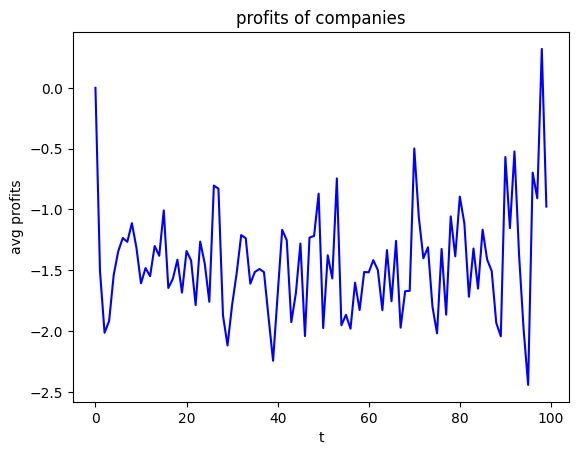

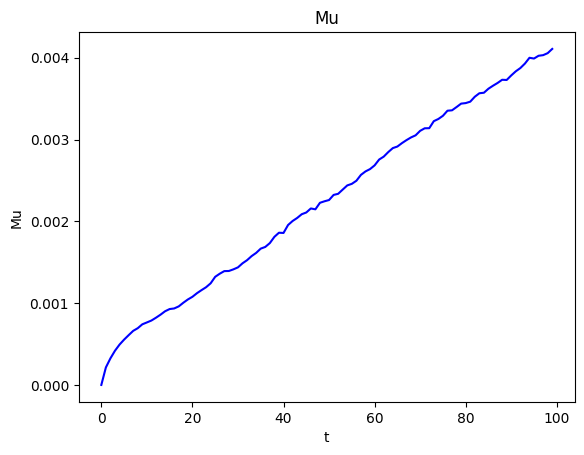

TypeError: unsupported operand type(s) for /: 'list' and 'int'

<Figure size 640x480 with 0 Axes>

In [4]:
def graph_zipf_density1(show=True):
    Statistics.log("zipf_density")
    plt.clf()
    zipf = {} # log K = freq
    for firm in Status.firms:
        if round(firm.K)>0:
            x = math.log( round(firm.K) )
            if x in zipf:
                zipf[x] += 1
            else:
                zipf[x] = 1
    x=[]
    y=[]
    for i in zipf:
        if math.log( zipf[i]) >= 1:
            x.append( i )
            y.append( math.log(zipf[i]))
    plt.plot(x, y, 'o', color="blue")
    plt.ylabel("log freq")
    plt.xlabel("log K")
    plt.title("Zipf plot of firm sizes (modified)")
    plt.show() if show else plt.savefig("zipf_density1.svg" )
    
def graph_zipf_rank(show=True):
    Statistics.log("zipf_rank")
    plt.clf()
    y = []  # log K = freq
    x = []
    for firm in Status.firms:
        if round(firm.K)>0:
            y.append( math.log( firm.K ) )
    y.sort(); y.reverse()
    for i in range(len(y)):
        x.append(math.log(float(i+1)))
    plt.plot( y,x, 'o', color="blue" )
    plt.xlabel("log K")
    plt.ylabel("log rank")
    plt.title("Rank of K (zipf)" )
    plt.show() if show else plt.savefig("zipf_rank.svg")

def graph_aggregate_output(show=True):
    Statistics.log("aggregate_output")
    plt.clf()
    xx1 = []
    yy = []
    rangemin = 150 if Config.T > 150 else 0
    for i in range(rangemin, Config.T):
        yy.append(i)
        xx1.append(math.log(Status.firmsKsums[i]))
    plt.plot(yy, xx1, 'b-')
    plt.ylabel("log K")
    plt.xlabel("t")
    plt.title("Logarithm of aggregate output" )
    plt.show() if show else plt.savefig("aggregate_output.svg")

def graph_profits(show=True):
    Statistics.log("profits")
    plt.clf()
    xx = []
    yy = []
    for i in range(Config.T):
            xx.append(i)
            yy.append( Statistics.firmsπ[i] / Config.N  )
    plt.plot(xx, yy, 'b-')
    plt.ylabel("avg profits")
    plt.xlabel("t")
    plt.title("profits of companies" )
    plt.show() if show else plt.savefig("profits.svg")

def graph_bankrupcies(show=True):
    Statistics.log("bankrupcies")
    plt.clf()
    xx = []
    yy = []
    for i in range(Config.T):
            xx.append(i)
            yy.append( Statistics.bankrupcy[i] )
    plt.plot(xx, yy, 'b-')
    plt.ylabel("num of bankrupcies")
    plt.xlabel("t")
    plt.title("Bankrupted firms")
    plt.show() if show else plt.savefig("bankrupted.svg")
    
def graph_baddebt(show=True):
    Statistics.log("bad_debt")
    plt.clf()
    xx = []
    yy = []
    rangemin = 150 if Config.T > 150 else 0
    for i in range(rangemin, Config.T):
            xx.append( i )
            yy.append( -Statistics.firmsB[i]/Config.N  )
    plt.plot(xx, yy, 'b-')
    plt.ylabel("avg bad debt")
    plt.xlabel("t")
    plt.title("Bad debt" )
    plt.show() if show else plt.savefig("bad_debt_avg.svg")

def graph_y(show=True):
    Statistics.log("y")
    plt.clf()
    xx = []
    yy = []
    for i in range(Config.T):
        xx.append(i)
        yy.append( math.log( Statistics.firmsY[i]) )
    plt.plot(xx, yy, 'b-')
    plt.ylabel("ln Y")
    plt.xlabel("t")
    plt.title("Y" )
    plt.show() if show else plt.savefig("y.svg" )

def graph_k(show=True):
    Statistics.log("k")
    plt.clf()
    xx = []
    yy = []
    for i in range(Config.T):
        xx.append(i)
        yy.append( math.log( Statistics.firmsK[i]) )
    plt.plot(xx, yy, 'b-')
    plt.ylabel("ln K")
    plt.xlabel("t")
    plt.title("K" )
    plt.show() if show else plt.savefig("k.svg" )

def graph_φ(show=True):
    Statistics.log("")
    plt.clf()
    xx = []
    yy = []
    for i in range(Config.T):
        xx.append(i)
        yy.append( Statistics.firmsφ[i] / Config.N )
    plt.plot(xx, yy, 'b-')
    plt.ylabel("Phi")
    plt.xlabel("t")
    plt.title("Phi" )
    plt.show() if show else plt.savefig("phi.svg" )
    
    
    
def graph_zeta(show=True):
    Statistics.log("zeta")
    plt.clf()
    xx = []
    yy = []
    for i in range(Config.T):
        xx.append(i)
        yy.append( Statistics.firmsz[i] / Config.N )
    plt.plot(xx, yy, 'b-')
    plt.ylabel("Zeta")
    plt.xlabel("t")
    plt.title("Zeta" )
    plt.show() if show else plt.savefig("zeta.svg" )
    
    
def graph_mu(show=True):
    Statistics.log("mu")
    plt.clf()
    xx = []
    yy = []
    for i in range(Config.T):
        xx.append(i)
        yy.append( Statistics.firmsmu[i] / Config.N  )
    plt.plot(xx, yy, 'b-')
    plt.ylabel("Mu")
    plt.xlabel("t")
    plt.title("Mu" )
    plt.show() if show else plt.savefig("mu.svg" )
    
def graph_zipf_density(show=True):
    Statistics.log("zipf_density")
    plt.clf()
    zipf = {} # log K = freq
    for firm in Status.firms:
        if round(firm.K)>0:
            x = math.log( round(firm.K) )
            if x in zipf:
                zipf[x] += 1
            else:
                zipf[x] = 1
    x=[]
    y=[]
    for i in zipf:
        x.append( i )
        y.append( math.log(zipf[i]))
    plt.plot(x, y, 'o', color="blue")
    plt.ylabel("log freq")
    plt.xlabel("log K")
    plt.title("Zipf plot of firm sizes" )
    plt.show() if show else plt.savefig("zipf_density.svg")
    
def graph_interest_rate(show):
    Statistics.log("interest_rate")
    plt.clf()
    xx2 = []
    yy = []
    rangemin = 150 if Config.T > 150 else 0
    for i in range(rangemin, Config.T):
        yy.append(i)
        xx2.append( Statistics.rate[i]  )
    plt.plot(yy, xx2, 'b-')
    plt.ylabel("mean rate")
    plt.xlabel("t")
    plt.title("Mean interest rates of companies")
    plt.show() if show else plt.savefig("interest_rate.svg")
    
def graph_growth_rate(show):
    Statistics.log("growth_rate")
    plt.clf()
    xx2 = []
    yy = []
    rangemin = 150 if Config.T > 150 else 0
    for i in range(rangemin, Config.T):
        if Status.firmsGrowRate[i]!=0:
            yy.append(i)
            xx2.append( Status.firmsGrowRate[i]  )
    plt.plot(yy, xx2, 'b-')
    plt.ylabel("growth")
    plt.xlabel("t")
    plt.title("Growth rates of agg output")
    plt.show() if show else plt.savefig("growth_rates.svg")

def graph_newentry(show=True):
    Statistics.log("newentry")
    plt.clf()
    xx = []
    yy = []
    for i in range(Config.T):
        xx.append(i)
        yy.append(determineNentry[i])
        addFirms(yy[-1])
    plt.plot(xx, yy, 'b-')
    plt.ylabel("New Entries")
    plt.xlabel("t")
    plt.title("New Entries")
    plt.show() if show else plt.savefig("newentry.svg")

def graph_bankrupcies(show=True):
    Statistics.log("bankrupcies")
    plt.clf()
    xx = []
    yy = []
    for i in range(0, Config.T):
            xx.append(i)
            yy.append( Statistics.bankrupcy[i] )
    plt.plot(xx, yy, 'b-')
    plt.ylabel("num of bankrupcies")
    plt.xlabel("t")
    plt.title("Bankrupted firms")
    plt.show() if show else plt.savefig("bankrupted.svg")
    
def show_graph(show):
    graph_profits(show)
    graph_mu(show)
    graph_zeta(show)
    graph_φ(show)
    #graph_k(show)
    #graph_y(show)
    #graph_interest_rate(show)
    #graph_growth_rate(show)
    #graph_baddebt(show)
    
def isNotebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True


if not isNotebook():
    Statistics.doLog = True
doSimulation()
show_graph(isNotebook())




In [ ]:
show_graph(isNotebook())

In [ ]:
graph_y(True)

In [ ]:
total=0
for i in Statistics.firmsz:
    for j in i:
        if j>0.001:
            # print(j)
            total+=1
print(total)

In [ ]:
zetavalues = Statistics.firmsz

# Create a line plot of the zeta values for all firms over time
for i in range(len(zetavalues)):
    plt.plot([i] * len(zetavalues[i]), zetavalues[i], 'b.', alpha=0.3)

plt.title("Zeta Values for All Firms over Time")
plt.xlabel("Time")
plt.ylabel("Zeta Value")
plt.show()

In [ ]:
graph_interest_rate(True)

In [ ]:
graph_φ(True)

In [ ]:
graph_baddebt(True)

In [ ]:
graph_k(True)

In [5]:
graph_newentry(True)

TypeError: 'function' object is not subscriptable

<Figure size 640x480 with 0 Axes>

In [ ]:
graph_bankrupcies(True)